# OFDM simulation using 64 QAM modulation
OFDM (Orthogonal frequency division multiplexing) is a multicarrier system that is applied in a wide range of wireless transmission systems, such as LTE, WiMAX and DVB-T and DAB. The fundamental concept of a multicarrier system is the division of a high-rate transmitted data stream into several low-rate narrow subcarriers. This way, several advantages are obtained:
- Since the symbol duration is inverse proportional to the symbol rate, each subcarrier has relatively long symbols. Long symbols are robust against multipath fading, as it occurs in wireless systems.
- When a carrier is in a deep fade due to frequency-selectivity of the channel (i.e. the received energy on this carrier is very low), only the data on this subcarrier is lost, instead of the whole stream.
- Multicarrier systems allow easy multi-user resource sharing by allocating different subcarriers to different users.

## Import libraries

In [1]:
import cv2 as cv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math as math
import requests
import scipy
from scipy.ndimage import gaussian_filter1d
import scipy.fftpack

## Define Functions

### Helper functions

In [2]:
def xor(a, b):
    # initialize result
    result = []
    # same, then XOR is 0, else 1
    for i in range(1, len(b)):
        if a[i] == b[i]:
            result.append('0')
        else:
            result.append('1')
    return ''.join(result)


def url2img(urls, RGB = False):
    resp = requests.get(urls, stream=True).raw
    img = np.asarray(bytearray(resp.read()), dtype="uint8")
    img = cv.imdecode(img, cv.IMREAD_COLOR)
    if RGB :
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img


def mod2div(divident, divisor):
    # Number of bits to be XORed at a time.
    pick = len(divisor)
    # Slicing the divident to appropriate
    # length for particular step
    tmp = divident[0 : pick]
    while pick < len(divident):
        if tmp[0] == '1':
            # replace the divident by the result
            # of XOR and pull 1 bit down
            tmp = xor(divisor, tmp) + divident[pick]
        else:
            # If the leftmost bit of the dividend (or the
            # part used in each step) is 0, the step cannot
            # use the regular divisor; we need to use an
            # all-0s divisor.
            tmp = xor('0'*pick, tmp) + divident[pick]

        # increment pick to move further
        pick += 1

    # For the last n bits, we have to carry it out
    # normally as increased value of pick will cause
    # Index Out of Bounds.
    if tmp[0] == '1':
        tmp = xor(divisor, tmp)
    else:
        tmp = xor('0'*pick, tmp)

    checkword = tmp
    return checkword


def encodeData(data, key):
    l_key = len(key)
    # Appends n-1 zeroes at end of data
    appended_data = data + '0'*(l_key-1)
    remainder = mod2div(appended_data, key)
    # Append remainder in the original data
    codeword = data + remainder
    return codeword


def decodeData(data, key):
    l_key = len(key)
    # Appends n-1 zeroes at end of data
    appended_data = data + '0'*(l_key-1)
    remainder = mod2div(appended_data, key)
    return remainder


def count_error(data):
    count = 0
    for i in data:
        if i != '000':
            if i!= '00':
                count += 1
    return count # number error bits


def split(word):
    return [char for char in word]


def resize_image(img_src, max_size):
    height, width = img_src.shape[:2] # Get the original image dimensions
    # Calculate the new dimensions while maintaining the aspect ratio
    if width > height:
        new_width = max_size
        new_height = int(max_size * (height / width))
    else:
        new_height = max_size
        new_width = int(max_size * (width / height))

    return cv.resize(img_src, (new_width, new_height), cv.INTER_LINEAR)


def rescale_image(img_src, scale):
    height, width = img_src.shape[:2] # Get the original image dimensions
    # Calculate the new dimensions based on the scale factor
    new_width = int(width * scale)
    new_height = int(height * scale)
    return cv.resize(img_src, (new_width, new_height), cv.INTER_LINEAR)

### Channel functions

In [3]:
def group_bits(bits, bits_per_group):
    bits_groups = []
    x = 0
    num_groups = (len(bits)//bits_per_group)+1
    for i in range(num_groups):
        bits_groups.append(bits[x:x+bits_per_group])
        x = x+bits_per_group
    bits_groups[-1] = np.zeros(bits_per_group, dtype = int)
    return bits_groups


def group_bits_zero_pad(bits, bits_per_group):
    num_groups = (len(bits) + bits_per_group - 1) // bits_per_group
    # Pad the bits list with zeros if needed
    bits_zero_pad = bits
    bits_zero_pad.resize(num_groups*bits_per_group, refcheck=False)
    # Use a list comprehension to create the groups
    bits_groups = [bits_zero_pad[i:i + bits_per_group] for i in range(0, len(bits), bits_per_group)]
    return bits_groups


def S2P(bits_serial : np.ndarray, length : int, mu : int):
    return bits_serial.reshape(length, mu)


def P2S(bits_parallel : np.ndarray):
    return bits_parallel.reshape((-1,))


def Mapping(bits, mapping_table):
    return np.array([mapping_table[tuple(b)] for b in bits])


def Demapping(QAM, demapping_table):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    # for each element in QAM, choose the index in constellation
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    # get back the real constellation point
    hardDecision = constellation[const_index]
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision


def OFDM_symbol(QAM_payload, K, dataCarriers, pilotCarriers, pilotValue):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol


def FFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)


def IFFT(OFDM_data):
    return np.fft.ifft(OFDM_data)


def addCP(OFDM_time, CP):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # add them to the beginning


def removeCP(signal, CP, K):
    return signal[CP:(CP+K)]


def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest


def get_payload(equalized, dataCarriers):
    return equalized[dataCarriers]


def channel(signal, channelResponse, snrdb):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-snrdb/10) # calculate noise power based on signal power and SNR
    # print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise


def channelEstimate(OFDM_demod, allCarriers, pilotCarriers, pilotValue):
    '''
    Perform interpolation between the pilot carriers to get an estimate
    of the channel in the data carriers. Here, we interpolate absolute value and phase
    separately
    '''
    pilots = OFDM_demod[pilotCarriers]      # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue    # divide by the transmitted pilot values
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    return Hest, Hest_at_pilots

## Main Simulation

### Parameters setup
First, let's define some parameters that will be using during the OFDM simulation:

In [4]:
save_fig = True # To save plot during simulation
save_folder = Path("results") # Where to save the figures

- `K` : The number of subcarriers, describes how many subcarriers are available in the OFDM system.
- `CP` : The length of the cyclic prefix, denotes the number of samples that are copied from the end of the modulated block to the beginning, to yield a cyclic extension of the block.
- `P` : The number of pilots in the OFDM symbol, describes how many carriers are used to transmit known information (i.e. pilots). Pilots will be used at the receiver to estimate the wireless channel between transmitter and receiver. Further, we also define the value that each pilots transmits (which is known to the receiver).
- `MU` : Since we simulating 64QAM transmission, we need to define $\mu = \log_{2} 64 = 6$ bits per symbol
- `SNRDB` : Signal-to-Noise Ratio in dB, that should occur at the receiver.

In [5]:
K = 128                                 # number of OFDM subcarriers
CP = K // 4                             # length of the cyclic prefix: 25% of the block
P = 8                                   # number of pilot carriers per OFDM block
MU = 6                                  # bits per symbol (64QAM)
SNRDB = 20                              # signal to noise-ratio in dB at the receiver

In [35]:
pilotValue = 7+7j                       # the known value each pilot transmits
allCarriers = np.arange(K)              # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P]     # pilots is every (K/P)th carrier.
# For convenience of channel estimation, the last carrier is also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1
# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)
print ("allCarriers:\n", allCarriers)
print ("pilotCarriers:\n", pilotCarriers)
print ("dataCarriers:\n", dataCarriers)

allCarriers:
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
pilotCarriers:
 [  0  14  28  42  56  70  84  98 112 126 127]
dataCarriers:
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18  19
  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38
  39  40  41  43  44  45  46  47  48  49  50  51  52  53  54  55  57  58
  59  60  61  62  63  64  65  66  67  68  69  71  72  73  74  75  76  77
  78  79  80  81  82  83  85  86  87  88  89  90  91  92  93  94  95  96
  97  99 100 101 102 10

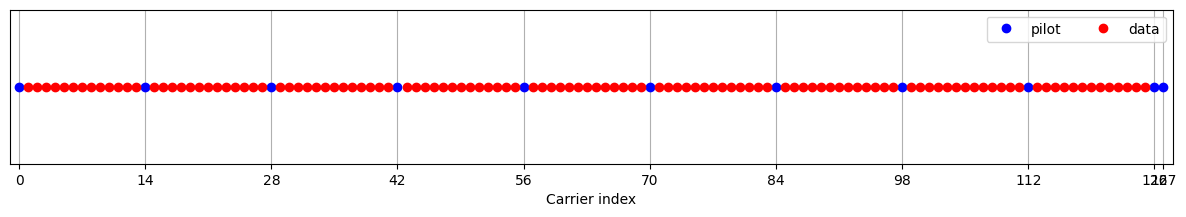

In [36]:
plt.figure(figsize=(15,2))
plt.xlim((-1, K))
plt.ylim((-1, 1))
plt.xlabel('Carrier index')
plt.yticks([])
plt.xticks(pilotCarriers)
plt.grid(True)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.legend(fontsize=10, ncol=2)
if save_fig : plt.savefig(save_folder/"carrier_index.pdf", bbox_inches='tight')
plt.show()

Now we define a `mapping_table` that map from groups of 6 bits to a 64QAM constellation symbol

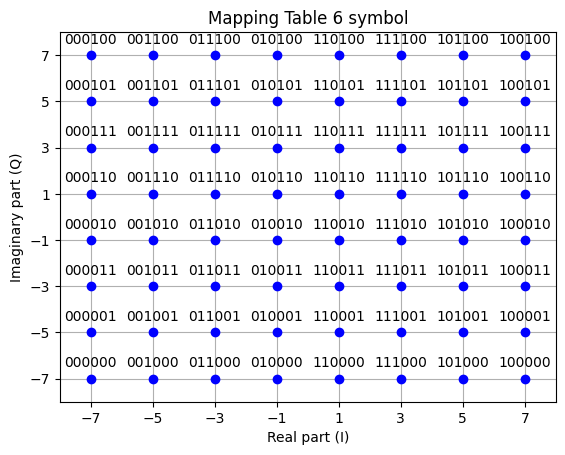

In [8]:
mapping_table = {
    (0,0,0,0,0,0) : -7-7j,
    (0,0,0,0,0,1) : -7-5j,
    (0,0,0,0,1,1) : -7-3j,
    (0,0,0,0,1,0) : -7-1j,
    (0,0,0,1,1,0) : -7+1j,
    (0,0,0,1,1,1) : -7+3j,
    (0,0,0,1,0,1) : -7+5j,
    (0,0,0,1,0,0) : -7+7j,
    (0,0,1,1,0,0) : -5+7j,
    (0,0,1,1,0,1) : -5+5j,
    (0,0,1,1,1,1) : -5+3j,
    (0,0,1,1,1,0) : -5+1j,
    (0,0,1,0,1,0) : -5-1j,
    (0,0,1,0,1,1) : -5-3j,
    (0,0,1,0,0,1) : -5-5j,
    (0,0,1,0,0,0) : -5-7j,
    (0,1,1,0,0,0) : -3-7j,
    (0,1,1,0,0,1) : -3-5j,
    (0,1,1,0,1,1) : -3-3j,
    (0,1,1,0,1,0) : -3-1j,
    (0,1,1,1,1,0) : -3+1j,
    (0,1,1,1,1,1) : -3+3j,
    (0,1,1,1,0,1) : -3+5j,
    (0,1,1,1,0,0) : -3+7j,
    (0,1,0,1,0,0) : -1+7j,
    (0,1,0,1,0,1) : -1+5j,
    (0,1,0,1,1,1) : -1+3j,
    (0,1,0,1,1,0) : -1+1j,
    (0,1,0,0,1,0) : -1-1j,
    (0,1,0,0,1,1) : -1-3j,
    (0,1,0,0,0,1) : -1-5j,
    (0,1,0,0,0,0) : -1-7j,
    (1,1,0,0,0,0) :  1-7j,
    (1,1,0,0,0,1) :  1-5j,
    (1,1,0,0,1,1) :  1-3j,
    (1,1,0,0,1,0) :  1-1j,
    (1,1,0,1,1,0) :  1+1j,
    (1,1,0,1,1,1) :  1+3j,
    (1,1,0,1,0,1) :  1+5j,
    (1,1,0,1,0,0) :  1+7j,
    (1,1,1,1,0,0) :  3+7j,
    (1,1,1,1,0,1) :  3+5j,
    (1,1,1,1,1,1) :  3+3j,
    (1,1,1,1,1,0) :  3+1j,
    (1,1,1,0,1,0) :  3-1j,
    (1,1,1,0,1,1) :  3-3j,
    (1,1,1,0,0,1) :  3-5j,
    (1,1,1,0,0,0) :  3-7j,
    (1,0,1,0,0,0) :  5-7j,
    (1,0,1,0,0,1) :  5-5j,
    (1,0,1,0,1,1) :  5-3j,
    (1,0,1,0,1,0) :  5-1j,
    (1,0,1,1,1,0) :  5+1j,
    (1,0,1,1,1,1) :  5+3j,
    (1,0,1,1,0,1) :  5+5j,
    (1,0,1,1,0,0) :  5+7j,
    (1,0,0,1,0,0) :  7+7j,
    (1,0,0,1,0,1) :  7+5j,
    (1,0,0,1,1,1) :  7+3j,
    (1,0,0,1,1,0) :  7+1j,
    (1,0,0,0,1,0) :  7-1j,
    (1,0,0,0,1,1) :  7-3j,
    (1,0,0,0,0,1) :  7-5j,
    (1,0,0,0,0,0) :  7-7j,
}
for d5 in [0,1]:
    for d4 in [0,1]:
        for d3 in [0,1]:
            for d2 in [0,1]:
                for d1 in [0,1]:
                    for d0 in [0,1]:
                        D = (d5,d4,d3,d2,d1,d0)
                        Q = mapping_table[D]
                        plt.plot(Q.real,Q.imag, 'bo')
                        plt.text(Q.real,Q.imag+0.5, "".join(str(x) for x in D), ha = 'center')
plt.grid(True)
plt.xticks(range(-7,8,2))
plt.yticks(range(-7,8,2))
plt.xlim((-8, 8))
plt.ylim((-8,8))
plt.xlabel('Real part (I)')
plt.ylabel('Imaginary part (Q)')
if save_fig : plt.savefig(save_folder/"mapping.pdf", bbox_inches='tight')
plt.title("Mapping Table 6 symbol")
plt.show()

Above, we have plotted the 64QAM constellation, along with the bit-labels. Note the Gray-mapping, i.e. two adjacent constellation symbols differ only by one bit and the other 3 bits remain the same. This technique helps to minimize bit-errors, in case a wrong constellation symbol is detected: Most probably, symbol errors are "off-by-one" errors, i.e. a symbol next to the correct symbol is detected. Then, only a single bit-error occurs.

The demapping table is simply the inverse mapping of the mapping table:

In [9]:
demapping_table = {v : k for k, v in mapping_table.items()}

Let us now define the wireless channel between transmitter and receiver. Here, we use a simple two-tap multipath channel with given impulse response `channelResponse`. Also, we plot the corresponding frequency response. As we see, the channel is frequency-selective.

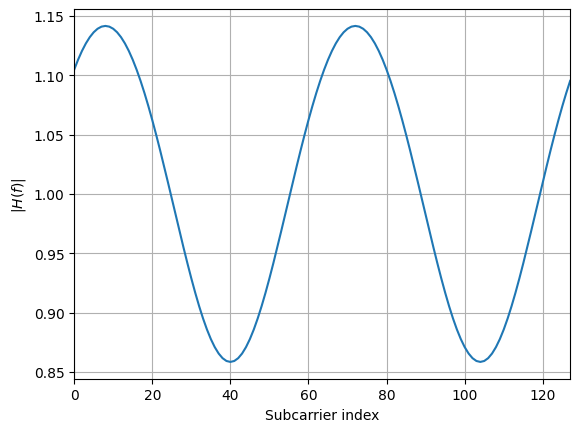

In [10]:
channelResponse = np.array([1, 0, 0.1+0.1j]) # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))
plt.xlabel('Subcarrier index')
plt.ylabel('$|H(f)|$')
plt.xlim(0, K-1)
plt.grid(True)
if save_fig : plt.savefig(save_folder/"channel.pdf", bbox_inches='tight')
plt.show()

### Transmitter Part
Now, that we have defined the necessary parameters for the OFDM system, we need some data for testing. Here we using a 3 channel image that can either load from a file or from an url

width, height, channel =  (256, 256, 3)


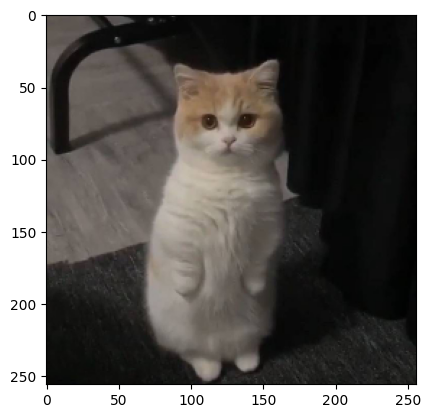

In [11]:
img = plt.imread("images/test.bmp") # Read Image from file
# img = url2img("https://sc04.alicdn.com/kf/Uc21f8e3d737e4cad81d95974852e0959I.jpg", RGB=True) # Read Image from URL
# Resize to reduce compute time
img = resize_image(img, 256) # neither side exceed 256 pixels 
print("width, height, channel = ", img.shape)
plt.imshow(img)
if save_fig : plt.savefig(save_folder/"input.pdf", bbox_inches='tight')
plt.show()

In [12]:
pixels = img.reshape(img.shape[0]*img.shape[1]*img.shape[2])
print(pixels.size)

196608


After that, we get all the pixels value (from 3 channels) of the image and lay them in a 1D array. This array is gonna have a size of `width x height x channel`

In [13]:
img_bytes = [format(pixel, "08b") for pixel in pixels]

The pixels value is in decimal, we need to convert it into binary

In [14]:
key = "1101"
img_en = [encodeData(i, key) for i in img_bytes]
print(img_bytes[1])
print(img_en[1])

01010101
01010101011


Subsequently, we add the CRC (Cyclic redundancy check) to the end of each byte.
Basically, the CRC generator at the transmitter consists of 4 steps:
1. Find the length of the devisor `L`
2. Append `L-1` bits to the original byte
3. Perform binary division operation to get `quotient` and `remainder`
4. Remainder of the division = `CRC`

<!-- | A | B | A XOR B|
|-|-|-|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0| -->

Here we choose the `key` value of `"1101"`

In [15]:
img_bits = [split(i) for i in np.array(img_en)]
img_bits = np.vstack(img_bits)
# img_ready_for_trans
img_bits_tx = np.array([int(i[j]) for i in img_bits for j in range(11)])

In [16]:
payloadBits_per_OFDM = len(dataCarriers)*MU # number of payload bits per OFDM symbol
bits_groups = group_bits_zero_pad(img_bits_tx, payloadBits_per_OFDM)

We group the bits into a group of `payloadBits_per_OFDM`, which in this case, equals 714

In [17]:
bits = np.array(bits_groups[0]) # we select first frame to send

For demonstration, in this part we sent only one frame, specifically, the first frame.

In [18]:
bits_parallel = S2P(bits, len(dataCarriers), MU) # Serial to Parallel
print ("First 5 bit groups:")
print (bits_parallel[:5,:])

First 5 bit groups:
[[0 1 0 1 1 1]
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]
 [1 0 1 1 0 1]
 [0 0 1 1 1 1]]


The `bits` are now sent to a serial-to-parallel converter, which groups the bits for the OFDM frame into a groups of $\mu$ bits (i.e. one group for each subcarrier):

Now, the `bits_parallel` are sent to the mapper. The mapper converts the groups into complex-valued constellation symbols according to the `mapping_table`.

In [19]:
QAM = Mapping(bits_parallel, mapping_table)
print ("First 5 QAM symbols:")
print (QAM[:5])

First 5 QAM symbols:
[-1.+3.j -7.-7.j  5.-1.j  5.+5.j -5.+3.j]


The next step (which isn't shown in the diagram) is the allocation of different subcarriers with data and pilots. For each subcarrier we have defined wether it carries data or a pilot by the arrays `dataCarriers` and `pilotCarriers`. Now, to create the overall OFDM data, we need to put the data and pilots into the OFDM carriers.

Next, the OFDM carriers contained in `OFDM_data` can be transformed to the time-domain by means of the `IFFT` operation. 

In [20]:
OFDM_data = OFDM_symbol(QAM, K, dataCarriers, pilotCarriers, pilotValue)
OFDM_time = IFFT(OFDM_data)

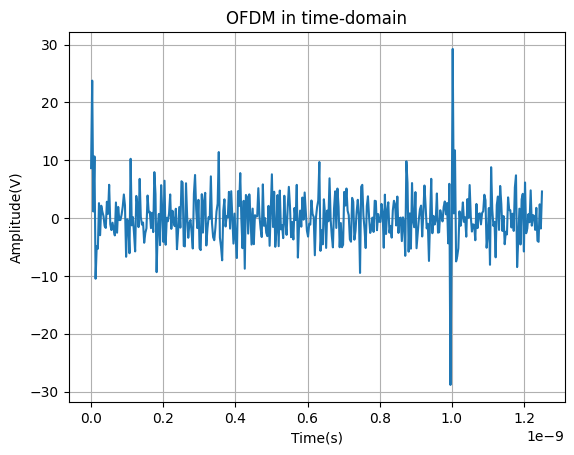

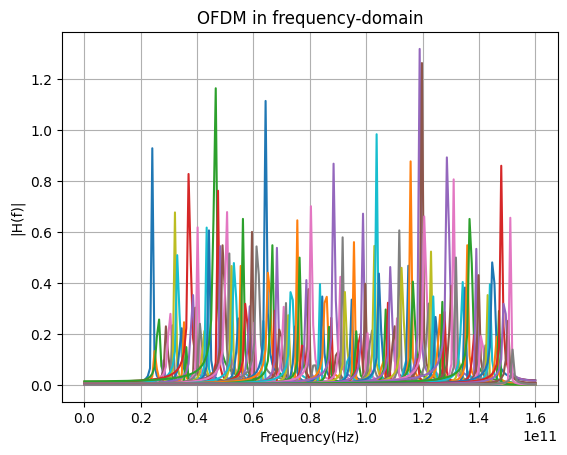

In [21]:
N = 400 # Number of sample points
T = 1 / 0.32e12 # sample spacing
t = np.linspace(0.0, N*T, N)
fd = 0
fc = 24e9

sin_time = []
for i in OFDM_time:
    sin_time.append(abs(i)*np.sin(((2*np.pi)*(fc+fd)*t) + math.atan(i.imag/i.real)))
    fd += 1e9
    
s = np.zeros(len(t), dtype = float)
for j in range(len(t)):
    for i in sin_time:
        s[j] += i[j]
        
# Time-domain
plt.plot(t,s)
plt.grid(True)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude(V)")
if save_fig: plt.savefig(save_folder/"time_domain_1.pdf", bbox_inches='tight')
plt.title("OFDM in time-domain")
plt.show()

# Frequency-domain
for i in range(len(sin_time)):
    yf = scipy.fftpack.fft(sin_time[i])
    xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.grid(True)
plt.ylabel("|H(f)|")
plt.xlabel("Frequency(Hz)")
if save_fig: plt.savefig(save_folder/"freq_domain_1.pdf", bbox_inches='tight')
plt.title("OFDM in frequency-domain")
plt.show()

Subsequently, we add a cyclic prefix to the symbol. This operation concatenates a copy of the last `CP` samples of the OFDM time domain signal to the beginning. This way, a cyclic extension is achieved. The CP fulfills two tasks:

1. It isolates different OFDM blocks from each other when the wireless channel contains multiple paths, i.e. is frequency-selective.
2. It turns the linear convolution with the channel into a circular one. Only with a circular convolution, we can use the single-tap equalization OFDM is so famous for.

In [22]:
OFDM_TX = addCP(OFDM_time, CP)

print("Number of OFDM carriers in frequency domain:     ", len(OFDM_data))
print("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))
print("Number of OFDM samples in time domain with CP:   ", len(OFDM_TX))

Number of OFDM carriers in frequency domain:      128
Number of OFDM samples in time-domain before CP:  128
Number of OFDM samples in time domain with CP:    160


Now, the signal is sent to the antenna and sent over the air to the receiver. In between both antennas, there is the wireless channel. We model this channel as a static multipath channel with impulse response `channelResponse`. Hence, the signal at the receive antenna is the convolution of the transmit signal with the channel response. Additionally, we add some noise to the signal according to the value of `SNRBD`

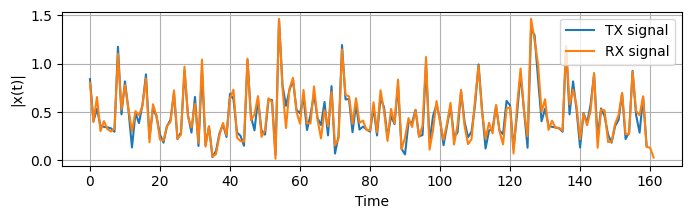

In [23]:
OFDM_RX = channel(OFDM_TX, channelResponse, SNRDB)

plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel("Time") 
plt.ylabel("|x(t)|")
plt.grid(True)
if save_fig : plt.savefig(save_folder/"tx_rx.pdf", bbox_inches='tight')
plt.show()

### Receiver Part
At receiver part, the `CP` is removed from the signal and a window of `K` samples is extracted from the received signal.

Afterwards, the signal is transformed back to the frequency domain, in order to have the received value on each subcarrier available.

As the next step, the wireless channel needs to be estimated. For illustration purposes, we resort to a simple zero-forcing channel estimation followed by a simple interpolation. The principle of channel estimation is as follows:

The transmit signal contains pilot values at certain pilot carriers. These pilot values and their position in the frequency domain (i.e. the pilot carrier index) are known to the receiver. From the received information at the pilot subcarriers, the receiver can estimate the effect of the wireless channel onto this subcarrier (because it knows what was transmitted and what was received). Hence, the receiver gains information about the wireless channel at the pilot carriers. However, it wants to know what happened at the data carriers. To achieve this, it interpolates the channel values between the pilot carriers to get an estimate of the channel in the data carriers.

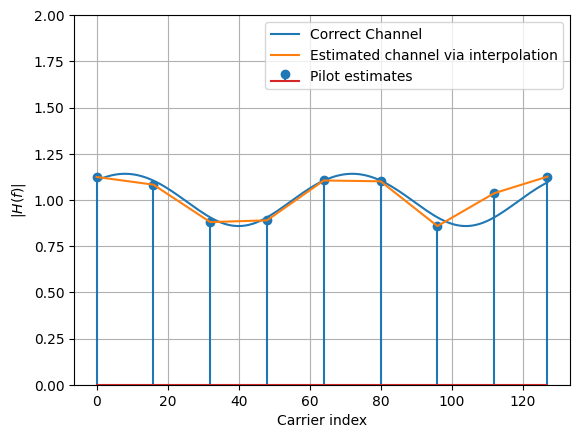

In [24]:

OFDM_RX_noCP = removeCP(OFDM_RX, CP, K)
OFDM_demod = FFT(OFDM_RX_noCP)
Hest, Hest_at_pilots = channelEstimate(OFDM_demod, allCarriers, pilotCarriers, pilotValue)

plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
plt.grid(True)
plt.xlabel('Carrier index')
plt.ylabel('$|H(f)|$')
plt.legend(fontsize=10)
plt.ylim(0,2)
if save_fig : plt.savefig(save_folder/"channel_estimation.pdf", bbox_inches='tight')
plt.show()

Now that the channel is estimated at all carriers, we can use this information in the channel equalizer step. Here, for each subcarrier, the influence of the channel is removed such that we get the clear (only noisy) constellation symbols back.

The next step (not shown in the diagram) is to extract the data carriers from the equalized symbol. Here, we throw away the pilot carriers, as they do not provide any information, but were used for the channel estimation process.

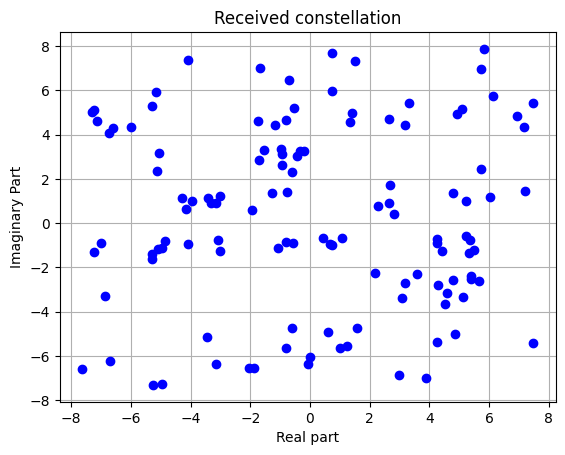

In [25]:
equalized_Hest = equalize(OFDM_demod, Hest)
QAM_est = get_payload(equalized_Hest, dataCarriers)
plt.plot(QAM_est.real, QAM_est.imag, 'bo', scalex = True, scaley = True)
plt.grid(True)
plt.xlabel('Real part')
plt.ylabel('Imaginary Part')
if save_fig : plt.savefig(save_folder/"data_carriers.pdf", bbox_inches='tight')
plt.title("Received constellation")
plt.show()

Now, that the constellation is obtained back, we need to send the complex values to the demapper, to transform the constellation points to the bit groups. In order to do this, we compare each received constellation point against each possible constellation point and choose the constellation point which is closest to the received point. Then, we return the bit-group that belongs to this point.

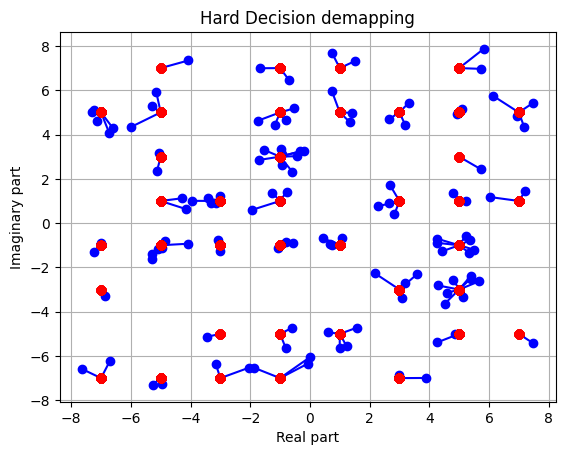

In [26]:
PS_est, hardDecision = Demapping(QAM_est, demapping_table)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o')
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')
plt.grid(True)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
if save_fig : plt.savefig(save_folder/"demapping.pdf", bbox_inches='tight')
plt.title('Hard Decision demapping')
plt.show()

In the diagram above, the blue points are the received QAM points, where as the the red points connected to them are the closest possible constellation points, and the bit groups corresponding to these red points are returned. 

Then, the bit groups need to be converted to a serial stream of bits, by means of parallel to serial conversion.

Finally, we can calculate the bit error rate

In [27]:
bits_est = P2S(PS_est)
ber = np.sum(abs(bits-bits_est))/len(bits)
print ("Obtained Bit error rate: ", ber)

Obtained Bit error rate:  0.012605042016806723


Now let send all the `bits` in `bits_groups` at once

In [28]:
total_ber = 0
bit_rx = []
for bits in bits_groups:
    bits_parallel = S2P(bits, len(dataCarriers), MU)
    QAM = Mapping(bits_parallel, mapping_table)
    OFDM_data = OFDM_symbol(QAM, K, dataCarriers, pilotCarriers, pilotValue)
    OFDM_time = IFFT(OFDM_data)
    OFDM_TX = addCP(OFDM_time, CP)
    OFDM_RX = channel(OFDM_TX, channelResponse, SNRDB)
    OFDM_RX_noCP = removeCP(OFDM_RX, CP, K)
    OFDM_demod = FFT(OFDM_RX_noCP)
    Hest, Hest_at_pilots = channelEstimate(OFDM_demod, allCarriers, pilotCarriers, pilotValue)
    equalized_Hest = equalize(OFDM_demod, Hest)
    QAM_est = get_payload(equalized_Hest, dataCarriers)
    PS_est, hardDecision = Demapping(QAM_est, demapping_table)
    bits_est = P2S(PS_est)
    ber = np.sum(abs(bits-bits_est))/len(bits)
    total_ber += ber
    bit_rx.append(bits_est)
    
print("Total BER is :" + str(ber / ((len(img_bits_tx)//payloadBits_per_OFDM)+1)))
print("All frames are sent")

Total BER is :1.3404701814719287e-05
All frames are sent


In [29]:
img_fr = [split(i) for i in np.array(bit_rx)]
img_fr = np.vstack(img_fr)

img_rfr = np.array([int(i[j]) for i in img_fr for j in range(payloadBits_per_OFDM)])

img_rfr1 = np.array([img_rfr[i] for i in range(len(img_bits_tx))])

img_rea = [img_rfr1[i:i+11] for i in range(0, len(img_rfr1), 11)]
    
img_done = [[str(j) for j in i] for i in img_rea]

img_fin = ["".join(i) for i in img_done]

Next we remove the redundant bits (CRC) to get the image data and calculate the error bits.
To check if the received byte is correct, we just need to perform division of the byte and the key, and the compare the remainder with zero. If the remainder is zero, the received byte is not contain error.

In [30]:
img_crc = [decodeData(i, key) for i in img_fin]

print("Amount of total bits:    ", len(img_bits_tx))
print("Amount of error bit(s):  ", count_error(img_crc))

Amount of total bits:     2162706
Amount of error bit(s):   50638


In [31]:
img_dec = np.array([i[0:8] for i in img_fin])

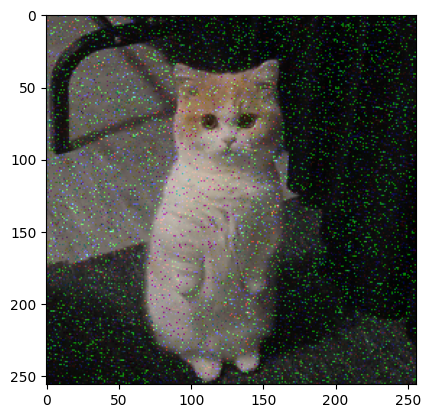

In [32]:
img_back = np.array([int(img_dec[i],2) for i in range(len(img_bytes))])
img_back = img_back.reshape(img.shape[0], img.shape[1], img.shape[2])
plt.imshow(img_back)
output_name = "output_"+str(SNRDB)+"db.pdf"
if save_fig: plt.savefig(save_folder/output_name, bbox_inches='tight')
plt.show()

### Analyzing the value of BER with SER varying from 0 to 40 db

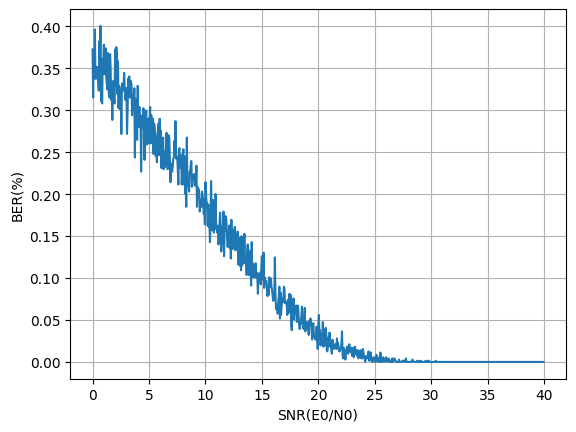

In [33]:
SNR_Array = np.arange(0, 40, 0.05)
bits = bits_groups[10]
BER_Array = []
for i in SNR_Array:
    bits_parallel = S2P(bits, len(dataCarriers), MU)
    QAM = Mapping(bits_parallel, mapping_table)
    OFDM_data = OFDM_symbol(QAM, K, dataCarriers, pilotCarriers, pilotValue)
    OFDM_time = IFFT(OFDM_data)
    OFDM_TX = addCP(OFDM_time, CP)
    OFDM_RX = channel(OFDM_TX, channelResponse, i)
    OFDM_RX_noCP = removeCP(OFDM_RX, CP, K)
    OFDM_demod = FFT(OFDM_RX_noCP)
    Hest, Hest_at_pilots = channelEstimate(OFDM_demod, allCarriers, pilotCarriers, pilotValue)
    equalized_Hest = equalize(OFDM_demod, Hest)
    QAM_est = get_payload(equalized_Hest, dataCarriers)
    PS_est, hardDecision = Demapping(QAM_est, demapping_table)
    bits_est = P2S(PS_est)
    ber = np.sum(abs(bits-bits_est))/len(bits)
    BER_Array.append(ber)

plt.plot(SNR_Array, BER_Array)
plt.xlabel("SNR(E0/N0)")
plt.ylabel("BER(%)")
plt.grid(True)
if save_fig: plt.savefig(save_folder/"ber.pdf", bbox_inches='tight')
plt.show()

Here we use `gaussian_filter1d` to smooth out the ber line

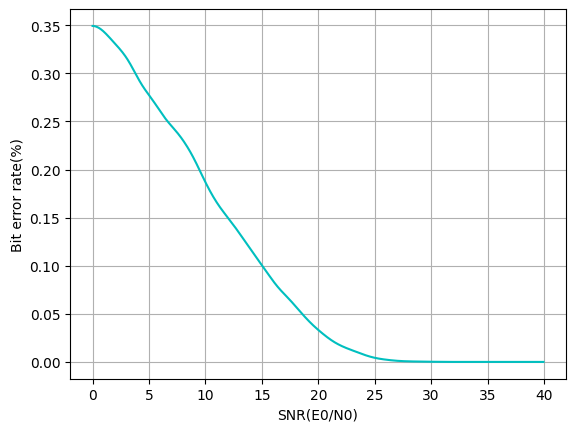

In [34]:
ysmoothed = gaussian_filter1d(BER_Array, sigma=15)
plt.plot(SNR_Array, ysmoothed, 'c')
plt.xlabel("SNR(E0/N0)")
plt.ylabel("Bit error rate(%)")
plt.grid(True)
if save_fig: plt.savefig(save_folder/"ber_smoothed.pdf", bbox_inches='tight')
plt.show()